# Mitigating Algorithmic Bias: Deep Learning-Based Analysis and Data Augmentation
Marc Bonhôte, Mikaël Schär, Viva Berlenghi

Group 35

Portions of this code were written or refined with assistance from Cursor AI (https://www.cursor.sh)

## Imports

In [1]:
from Toxigen_dataset import ToxiGenDataset
from Toxigen_model import Toxigen_Model
from data_augmentation import DataAugmentor

from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
from datasets import Dataset

c:\Users\mbonh\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Sub-sample Bool for the screencast

In [2]:
# Set the SUB_SAMPLE variable to True to use the sub-sample of the dataset
SUB_SAMPLE = True

## Load ToxiGen dataset

In [3]:
# Initialize and load the ToxiGen dataset
HUGGING_FACE_TOKEN = "your token here"
toxigen_handler = ToxiGenDataset(HUGGING_FACE_TOKEN)
toxigen_dataset = toxigen_handler.load_dataset()

### Print statistics

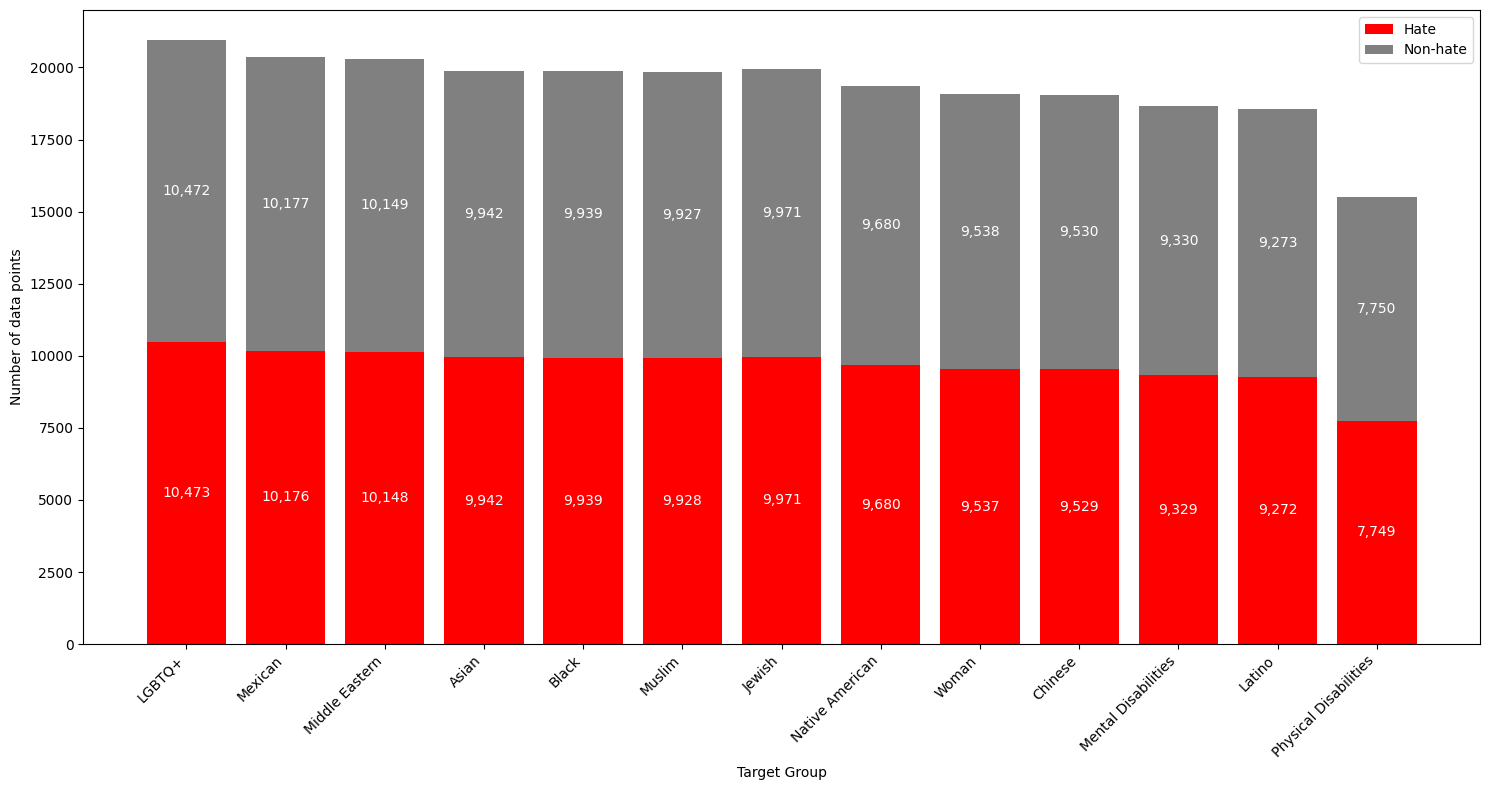

In [4]:

# Create lists for categories and counts
categories = ['LGBTQ+', 'Mexican', 'Middle Eastern', 'Asian', 'Black', 'Muslim', 'Jewish', 
             'Native American', 'Woman', 'Chinese', 'Mental Disabilities', 'Latino', 'Physical Disabilities']
counts_hate = [10473, 10176, 10148, 9942, 9939, 9928, 9971, 9680, 9537, 9529, 9329, 9272, 7749]
counts_nonhate = [10472, 10177, 10149, 9942, 9939, 9927, 9971, 9680, 9538, 9530, 9330, 9273, 7750]

# Set up the bar plot
plt.figure(figsize=(15, 8))

# Create stacked bars
plt.bar(categories, counts_hate, color='#ff0000', label='Hate')
plt.bar(categories, counts_nonhate, bottom=counts_hate, color='#808080', label='Non-hate')

# Customize the plot
plt.xticks(rotation=45, ha='right')
#plt.title('Distribution of Hate vs Non-hate for ToxiGen pre-train dataset', pad=20)
plt.xlabel('Target Group')
plt.ylabel('Number of data points')
plt.legend()

# Add value labels in the middle of each segment
for i, (hate, nonhate) in enumerate(zip(counts_hate, counts_nonhate)):
    # Label for hate segment
    plt.text(i, hate/2, f'{hate:,}', ha='center', va='center', color='white')
    # Label for non-hate segment
    plt.text(i, hate + nonhate/2, f'{nonhate:,}', ha='center', va='center', color='white')

# Adjust layout to prevent label cutoff
plt.tight_layout()
# Show the plot
plt.savefig('ToxiGen_pre-train_dataset_distribution.png', dpi=300)
plt.show()


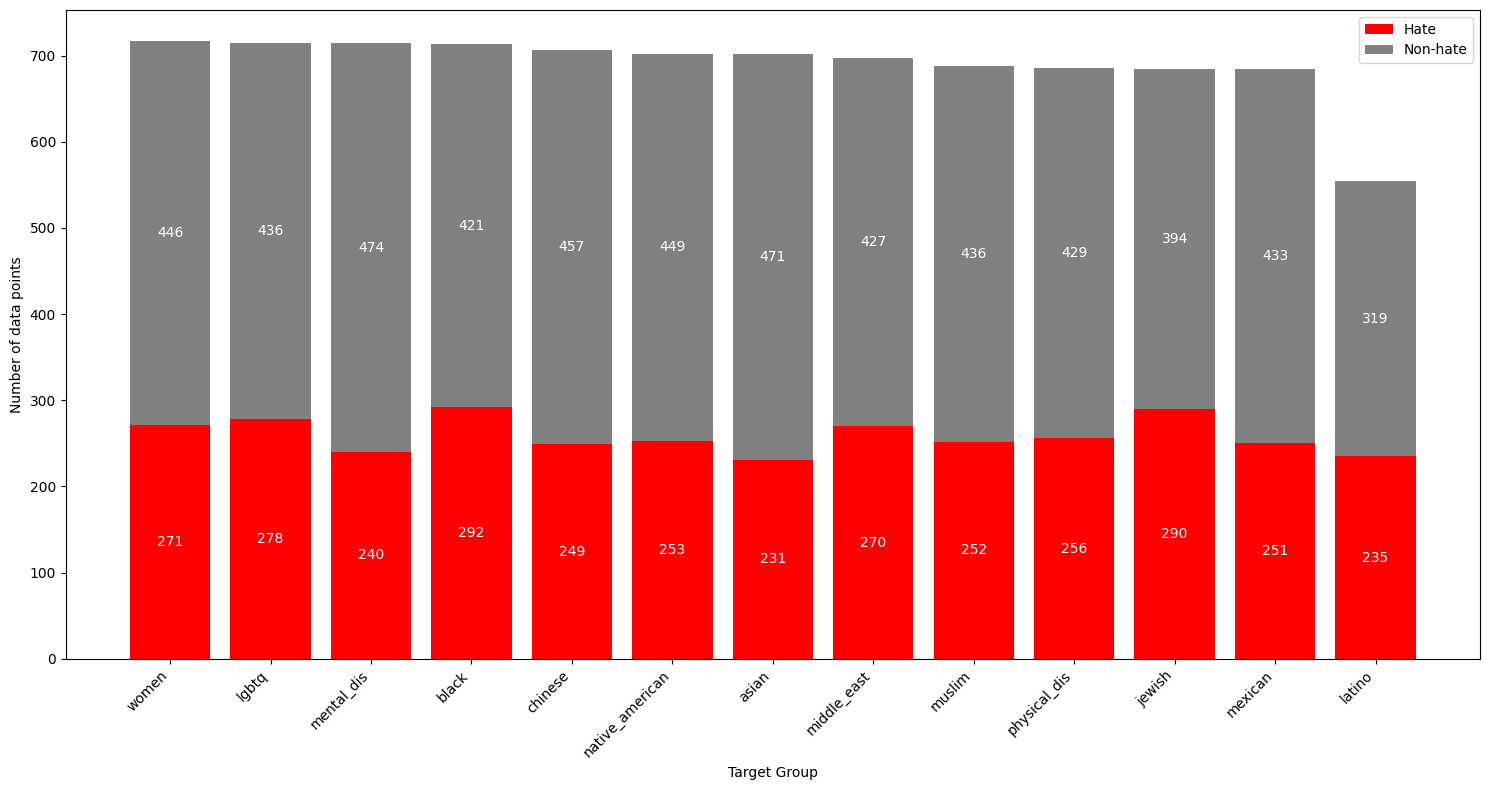

=== Dataset Statistics ===

Number of examples:
- train: 8960
- test: 940

Label Distribution:

Train split:
- Hate speech: 3368 (37.6%)
- Non-hate speech: 5592 (62.4%)

Test split:
- Hate speech: 406 (43.2%)
- Non-hate speech: 534 (56.8%)

Target Group Distribution:

Train split:
- asian: 702 (7.8%)
- black: 713 (8.0%)
- chinese: 706 (7.9%)
- jewish: 684 (7.6%)
- latino: 554 (6.2%)
- lgbtq: 714 (8.0%)
- mental_dis: 714 (8.0%)
- mexican: 684 (7.6%)
- middle_east: 697 (7.8%)
- muslim: 688 (7.7%)
- native_american: 702 (7.8%)
- physical_dis: 685 (7.6%)
- women: 717 (8.0%)

Test split:
- asian: 51 (5.4%)
- black: 92 (9.8%)
- chinese: 77 (8.2%)
- jewish: 87 (9.3%)
- latino: 61 (6.5%)
- lgbtq: 66 (7.0%)
- mental_dis: 68 (7.2%)
- mexican: 73 (7.8%)
- middle_east: 68 (7.2%)
- muslim: 83 (8.8%)
- native_american: 54 (5.7%)
- physical_dis: 95 (10.1%)
- women: 65 (6.9%)



In [5]:
toxigen_handler.print_statistics()

## HateERT Model with ToxiGen dataset

### Load the pre-trained HateBERT model

In [6]:
# Initialize HateBERT classifier
model_toxigen_hateBERT = Toxigen_Model(
    model_name="tomh/toxigen_hatebert",
    num_labels=2,
    device=None,  # Will automatically detect cuda/cpu
    max_length=512
)

INFO:Toxigen_model:Using device: cpu
INFO:Toxigen_model:Model tomh/toxigen_hatebert and tokenizer initialized successfully


### Tokenize ToxiGen dataset

In [7]:
# Tokenize function is now handled by HateBERT's prepare_inputs method
# We can directly use the tokenizer from our hatebert instance
tokenizer = model_toxigen_hateBERT.tokenizer

def tokenize_function(tokenizer, example, text_field):
    """
    Tokenize texts using the HateBERT tokenizer.

    Args:
        tokenizer: HateBERT tokenizer
        example: Dataset example
        text_field: Name of the text field to tokenize

    Returns:
        Tokenized features
    """
    # Tokenize the texts
    tokenized = tokenizer(
        example[text_field],
        padding='max_length',
        truncation=True,
        max_length=512,
        return_tensors='pt'
    )

    # Convert to lists for dataset storage
    return {
        'input_ids': tokenized['input_ids'].squeeze().tolist(),
        'attention_mask': tokenized['attention_mask'].squeeze().tolist()
    }

'''
 apply the function to all the elements in the dataset (individually or in batches)
 https://huggingface.co/docs/datasets/v1.11.0/package_reference/main_classes.html?highlight=dataset%20map#datasets.Dataset.map
 batch mode is very powerful. It allows you to speed up processing
 more info here: https://huggingface.co/docs/datasets/en/about_map_batch
'''
cache_files = {
    "test": ".cache/datasets/toxigen/toxigen_test_tokenized.arrow",
    "train": ".cache/datasets/toxigen/toxigen_train_tokenized.arrow"
} #path to the local cache files, where the current computation from the following function will be stored.
# Caching saves RAM when working with large datasets and saves time instead of doing transformations on the fly.
tokenized_toxigen = toxigen_dataset.map(lambda x: tokenize_function(tokenizer, x, "text"), batched=True, cache_file_names=cache_files)

In [8]:
# create a smaller subset of the dataset as previously shown to speed up the fine-tuning
if SUB_SAMPLE:
    small_train_dataset = tokenized_toxigen["train"].shuffle(seed=42).select(range(100))
    small_eval_dataset = tokenized_toxigen["test"].shuffle(seed=42).select(range(20))
else:
    small_train_dataset = tokenized_toxigen["train"].shuffle(seed=42)
    small_eval_dataset = tokenized_toxigen["test"].shuffle(seed=42)

In [9]:
# create a DataLoader for your training and test datasets so you can iterate over batches of data:
train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=8)
test_dataloader = DataLoader(small_eval_dataset, batch_size=8)

### Evaluate the pre-trained HateBERT model (with the annotated test set)

In [10]:
def evaluate_model_by_target_group(test_dataloader, predictions, target_groups=None):
    """
    Compute confusion matrix, F1 score and accuracy for each target group.

    Args:
        test_dataloader: DataLoader containing test data
        predictions: Model predictions array
        target_groups: Optional list of target groups to evaluate specifically
    """

    # Extract all labels and target groups from test dataloader
    all_labels = []
    all_target_groups = []

    for batch in test_dataloader:
        all_labels.extend(batch['labels'].numpy())
        all_target_groups.extend(batch['target_group'])

    # Get unique target groups if not specified
    if target_groups is None:
        target_groups = list(set(all_target_groups))

    print("Overall metrics:")
    print("Confusion Matrix:")
    print(confusion_matrix(all_labels, predictions))
    print(f"F1 Score: {f1_score(all_labels, predictions):.4f}")
    print(f"Accuracy: {accuracy_score(all_labels, predictions):.4f}\n")

    print("Metrics by target group:")
    for group in target_groups:
        # Get indices for this target group
        group_indices = [i for i, g in enumerate(all_target_groups) if g == group]

        if len(group_indices) == 0:
            continue

        # Get predictions and labels for this group
        group_preds = predictions[group_indices]
        group_labels = [all_labels[i] for i in group_indices]

        print(f"\nTarget Group: {group}")
        print("Confusion Matrix:")
        print(confusion_matrix(group_labels, group_preds))
        print(f"F1 Score: {f1_score(group_labels, group_preds):.4f}")
        print(f"Accuracy: {accuracy_score(group_labels, group_preds):.4f}")

In [11]:
model_toxigen_hateBERT.train(train_dataloader=train_dataloader,
                     num_epochs=5,
                     learning_rate=2e-5,
                     save_path=None)

c:\Users\mbonh\AppData\Local\Programs\Python\Python313\Lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
INFO:Toxigen_model:Epoch 1/5
Training:   0%|          | 0/13 [00:00<?, ?it/s]c:\Users\mbonh\Documents\EPFL\cours\MFE_Master_4\Deep Learning\Project\deep_learning2025\Toxigen_model.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs['labels'] = torch.tensor(labels).to(self.device)
Training: 100%|██████████| 13/13 [01:30<00:00,  6.94s/it, loss=0.363]
INFO:Toxigen_model:Epoch 1 - Train Loss: 1.1605, Train Accuracy: 0.5000
INFO:Toxigen_model:Epoch 2/5
Training:   0%|          | 0/13 [00:00<?, ?it/

{'train_loss': [1.1604960721272688,
  0.6391213536262512,
  0.6049732222006872,
  0.5649619240027207,
  0.5596205213895211],
 'train_accuracy': [0.5, 0.69, 0.69, 0.7, 0.75]}

In [12]:
preds, _ = model_toxigen_hateBERT.predict(test_dataloader, return_probs=True)
evaluate_model_by_target_group(test_dataloader, preds)

Testing: 100%|██████████| 3/3 [00:07<00:00,  2.40s/it]


Overall metrics:
Confusion Matrix:
[[11  2]
 [ 7  0]]
F1 Score: 0.0000
Accuracy: 0.5500

Metrics by target group:

Target Group: middle_east
Confusion Matrix:
[[0 0]
 [2 0]]
F1 Score: 0.0000
Accuracy: 0.0000

Target Group: muslim
Confusion Matrix:
[[1 0]
 [1 0]]
F1 Score: 0.0000
Accuracy: 0.5000

Target Group: latino
Confusion Matrix:
[[1]]
F1 Score: 0.0000
Accuracy: 1.0000

Target Group: lgbtq
Confusion Matrix:
[[2]]
F1 Score: 0.0000
Accuracy: 1.0000

Target Group: black
Confusion Matrix:
[[1 0]
 [2 0]]
F1 Score: 0.0000
Accuracy: 0.3333

Target Group: physical_dis
Confusion Matrix:
[[1 1]
 [1 0]]
F1 Score: 0.0000
Accuracy: 0.3333

Target Group: mental_dis
Confusion Matrix:
[[1 0]
 [1 0]]
F1 Score: 0.0000
Accuracy: 0.5000

Target Group: chinese
Confusion Matrix:
[[1]]
F1 Score: 0.0000
Accuracy: 1.0000

Target Group: mexican
Confusion Matrix:
[[3]]
F1 Score: 0.0000
Accuracy: 1.0000

Target Group: asian
Confusion Matrix:
[[0 1]
 [0 0]]
F1 Score: 0.0000
Accuracy: 0.0000


c:\Users\mbonh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\mbonh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mbonh\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\mbonh\AppData\Local\Programs\Python\Python31

## Data Augmentation
### Define the target groups to augment

In [13]:
# Define target groups that need augmentation
target_groups_to_augment = [
    'jewish',
    'asian', # Low F1 score
    'chinese',  # Low F1 score
    'latino'  # Moderate F1 score
]

### Back-translation method

In [14]:
# Initialize HateBERT classifier
model_toxigen_hateBERT = Toxigen_Model(
    model_name="tomh/toxigen_hatebert",
    num_labels=2,
    device=None,  # Will automatically detect cuda/cpu
    max_length=512
)
tokenizer = model_toxigen_hateBERT.tokenizer

#  Augmentation: Back-translation only
back_trans_augmentor = DataAugmentor(
    use_back_translation=True
    )
back_trans_dataset = back_trans_augmentor.augment_dataset(
    dataset=toxigen_dataset,
    target_groups=target_groups_to_augment,
    augmentation_factor=3
)
augmented_back_trans = Dataset.from_dict(back_trans_dataset['train'])
tokenized_augmented_back_trans_train = augmented_back_trans.map(
    lambda x: tokenize_function(tokenizer, x, "text"),
    batched=True
)
dataloader_augmented_back_trans_train = DataLoader(
    tokenized_augmented_back_trans_train,
    shuffle=True,
    batch_size=8
)

# Train the model
model_toxigen_hateBERT.train(train_dataloader=dataloader_augmented_back_trans_train,
                     num_epochs=5,
                     learning_rate=2e-5,
                     save_path=None)

# Evaluate the model
preds, _ = model_toxigen_hateBERT.predict(test_dataloader, return_probs=True)
evaluate_model_by_target_group(test_dataloader, preds)

INFO:Toxigen_model:Using device: cpu
INFO:Toxigen_model:Model tomh/toxigen_hatebert and tokenizer initialized successfully
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mbonh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mbonh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
INFO:data_augmentation:Initializing translation models...
ERROR:data_augmentation:Error initializing translation models: 
MarianTokenizer requires the SentencePiece library but it was not found in your environment. Checkout the instructions on the
installation page of its repo: https://github.com/google/sentencepiece#installation and follow the ones
that match your environment.

INFO:data_augmentation:
Processing train split...
INFO:data_augmentation:Adding original examples...
Original examples:   6%|▌         | 529/8960 [02:18<36:43,  3.83it/s]  


KeyboardInterrupt: 

### Random deletion method

In [ ]:
# Initialize HateBERT classifier
model_toxigen_hateBERT = Toxigen_Model(
    model_name="tomh/toxigen_hatebert",
    num_labels=2,
    device=None,  # Will automatically detect cuda/cpu
    max_length=512
)
tokenizer = model_toxigen_hateBERT.tokenizer

#  Augmentation: Random deletion only
deletion_augmentor = DataAugmentor(
    use_random_deletion=True
    )
deletion_dataset = deletion_augmentor.augment_dataset(
    dataset=toxigen_dataset,
    target_groups=target_groups_to_augment,
    augmentation_factor=3
)
augmented_deletion = Dataset.from_dict(deletion_dataset['train'])
tokenized_augmented_deletion_train = augmented_deletion.map(
    lambda x: tokenize_function(tokenizer, x, "text"),
    batched=True
)
dataloader_augmented_deletion_train = DataLoader(
    tokenized_augmented_deletion_train,
    shuffle=True,
    batch_size=8
)

# Train the model
model_toxigen_hateBERT.train(train_dataloader=dataloader_augmented_deletion_train,
                     num_epochs=5,
                     learning_rate=2e-5,
                     save_path=None)

# Evaluate the model
preds, _ = model_toxigen_hateBERT.predict(test_dataloader, return_probs=True)
evaluate_model_by_target_group(test_dataloader, preds)

### Synonym replacement method

In [ ]:
# Initialize HateBERT classifier
model_toxigen_hateBERT = Toxigen_Model(
    model_name="tomh/toxigen_hatebert",
    num_labels=2,
    device=None,  # Will automatically detect cuda/cpu
    max_length=512
)
tokenizer = model_toxigen_hateBERT.tokenizer

#  Augmentation: Synonym replacement only
wsd_augmentor = DataAugmentor(
    use_synonym_replacement=True
    )
wsd_dataset = wsd_augmentor.augment_dataset(
    dataset=toxigen_dataset,
    target_groups=target_groups_to_augment,
    augmentation_factor=3
)
augmented_wsd = Dataset.from_dict(wsd_dataset['train'])
tokenized_augmented_wsd_train = augmented_wsd.map(
    lambda x: tokenize_function(tokenizer, x, "text"),
    batched=True
)
dataloader_augmented_wsd_train = DataLoader(
    tokenized_augmented_wsd_train,
    shuffle=True,
    batch_size=8
)

# Train the model
model_toxigen_hateBERT.train(train_dataloader=dataloader_augmented_wsd_train,
                     num_epochs=5,
                     learning_rate=2e-5,
                     save_path=None)

# Evaluate the model
preds, _ = model_toxigen_hateBERT.predict(test_dataloader, return_probs=True)
evaluate_model_by_target_group(test_dataloader, preds)

### Paraphrasing method

In [ ]:
# Initialize HateBERT classifier
model_toxigen_hateBERT = Toxigen_Model(
    model_name="tomh/toxigen_hatebert",
    num_labels=2,
    device=None,  # Will automatically detect cuda/cpu
    max_length=512
)
tokenizer = model_toxigen_hateBERT.tokenizer

#  Augmentation: Paraphrasing only
paraphrase_augmentor = DataAugmentor(
    use_paraphrasing=True)
paraphrase_dataset = paraphrase_augmentor.augment_dataset(
    dataset=toxigen_dataset,
    target_groups=target_groups_to_augment,
    augmentation_factor=3
)
augmented_paraphrase = Dataset.from_dict(paraphrase_dataset['train'])
tokenized_augmented_paraphrase_train = augmented_paraphrase.map(
    lambda x: tokenize_function(tokenizer, x, "text"),
    batched=True
)
dataloader_augmented_paraphrase_train = DataLoader(
    tokenized_augmented_paraphrase_train,
    shuffle=True,
    batch_size=8
)

# Train the model
model_toxigen_hateBERT.train(train_dataloader=dataloader_augmented_paraphrase_train,
                     num_epochs=5,
                     learning_rate=2e-5,
                     save_path=None)

# Evaluate the model
preds, _ = model_toxigen_hateBERT.predict(test_dataloader, return_probs=True)
evaluate_model_by_target_group(test_dataloader, preds)

### All combined

In [ ]:
# Initialize HateBERT classifier
model_toxigen_hateBERT = Toxigen_Model(
    model_name="tomh/toxigen_hatebert",
    num_labels=2,
    device=None,  # Will automatically detect cuda/cpu
    max_length=512
)
tokenizer = model_toxigen_hateBERT.tokenizer

# Augmentation: All techniques combined
combined_augmentor = DataAugmentor(
    use_back_translation=True,
    use_synonym_replacement=True,
    use_random_deletion=True,
    use_paraphrasing=True
)
combined_dataset = combined_augmentor.augment_dataset(
    dataset=toxigen_dataset,
    target_groups=target_groups_to_augment,
    augmentation_factor=3
)
augmented_combined = Dataset.from_dict(combined_dataset['train'])
tokenized_augmented_combined_train = augmented_combined.map(
    lambda x: tokenize_function(tokenizer, x, "text"),
    batched=True
)
dataloader_augmented_combined_train = DataLoader(
    tokenized_augmented_combined_train,
    shuffle=True,
    batch_size=8
)

# Train the model
model_toxigen_hateBERT.train(train_dataloader=dataloader_augmented_combined_train,
                     num_epochs=5,
                     learning_rate=2e-5,
                     save_path=None)

# Evaluate the model
preds, _ = model_toxigen_hateBERT.predict(test_dataloader, return_probs=True)
evaluate_model_by_target_group(test_dataloader, preds)